In [2]:
import pandas as pd
import os
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LSTM
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
def load_data(dataset_path='./npy_files'):
    X = np.load(os.path.join(dataset_path,'X.npy'))
    y = np.load(os.path.join(dataset_path,'y.npy'))
    folds = np.load(os.path.join(dataset_path,'folds.npy'))
    feature_class = np.load(os.path.join(dataset_path, 'feature_class.npy'))
    facs = pd.read_csv('save_data/npy_files/facs_multi.csv',index_col=None)

    # rescale [0,255] -> [0,2]    
    X = X.astype('float32')/255*2

    # one-hot encode the labels
    num_classes = len(np.unique(y))
    y = keras.utils.to_categorical(y, num_classes)

    return X, y, folds, feature_class, facs

In [9]:
X, y, folds, feature_class, facs = load_data('./save_data/npy_files/')

In [11]:
del facs['Unnamed: 0']

In [38]:
from sklearn.model_selection import train_test_split

In [23]:
feature_class_single = np.zeros((1307, 4040))
for index, inst in enumerate(feature_class):
    feature_class_single[index] = inst[0]

In [40]:
feature_train, feature_test, facs_train, facs_test = \
        train_test_split(feature_class_single, facs, test_size=0.2)

In [76]:
def make_model():
    inputs = Input(shape=(4040,))
    h1 = Dense(1000, activation='relu')(inputs)
    h2 = Dense(500, activation='relu')(inputs)
    prediction = Dense(18, activation='sigmoid')(h2)
    
    dense_model = Model(inputs=inputs, outputs=prediction)
    sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-5, momentum=0.9)
    dense_model.compile(loss='binary_crossentropy', optimizer=sgd,
             metrics=['accuracy'])
    
    return dense_model

In [77]:
dense_model = make_model()

In [78]:
hist = dense_model.fit(feature_train, facs_train, batch_size=64, epochs=1000,
            validation_data=(feature_test, facs_test),
            verbose=2, shuffle=True)

Train on 1045 samples, validate on 262 samples
Epoch 1/1000
 - 0s - loss: 0.7828 - acc: 0.5350 - val_loss: 0.7569 - val_acc: 0.5492
Epoch 2/1000
 - 0s - loss: 0.7099 - acc: 0.5943 - val_loss: 0.6830 - val_acc: 0.6168
Epoch 3/1000
 - 0s - loss: 0.6400 - acc: 0.6592 - val_loss: 0.6259 - val_acc: 0.6800
Epoch 4/1000
 - 0s - loss: 0.5887 - acc: 0.7130 - val_loss: 0.5844 - val_acc: 0.7224
Epoch 5/1000
 - 0s - loss: 0.5513 - acc: 0.7557 - val_loss: 0.5547 - val_acc: 0.7530
Epoch 6/1000
 - 0s - loss: 0.5245 - acc: 0.7802 - val_loss: 0.5327 - val_acc: 0.7740
Epoch 7/1000
 - 0s - loss: 0.5045 - acc: 0.7962 - val_loss: 0.5160 - val_acc: 0.7877
Epoch 8/1000
 - 0s - loss: 0.4891 - acc: 0.8069 - val_loss: 0.5030 - val_acc: 0.7939
Epoch 9/1000
 - 0s - loss: 0.4769 - acc: 0.8136 - val_loss: 0.4925 - val_acc: 0.8013
Epoch 10/1000
 - 0s - loss: 0.4669 - acc: 0.8173 - val_loss: 0.4837 - val_acc: 0.8062
Epoch 11/1000
 - 0s - loss: 0.4584 - acc: 0.8206 - val_loss: 0.4762 - val_acc: 0.8073
Epoch 12/1000
 -

Epoch 96/1000
 - 0s - loss: 0.2866 - acc: 0.8973 - val_loss: 0.3144 - val_acc: 0.8840
Epoch 97/1000
 - 0s - loss: 0.2857 - acc: 0.8980 - val_loss: 0.3136 - val_acc: 0.8844
Epoch 98/1000
 - 0s - loss: 0.2848 - acc: 0.8986 - val_loss: 0.3127 - val_acc: 0.8851
Epoch 99/1000
 - 0s - loss: 0.2840 - acc: 0.8994 - val_loss: 0.3119 - val_acc: 0.8857
Epoch 100/1000
 - 0s - loss: 0.2831 - acc: 0.9000 - val_loss: 0.3111 - val_acc: 0.8863
Epoch 101/1000
 - 0s - loss: 0.2822 - acc: 0.9003 - val_loss: 0.3103 - val_acc: 0.8870
Epoch 102/1000
 - 0s - loss: 0.2814 - acc: 0.9007 - val_loss: 0.3095 - val_acc: 0.8868
Epoch 103/1000
 - 0s - loss: 0.2805 - acc: 0.9007 - val_loss: 0.3087 - val_acc: 0.8868
Epoch 104/1000
 - 0s - loss: 0.2797 - acc: 0.9013 - val_loss: 0.3079 - val_acc: 0.8872
Epoch 105/1000
 - 0s - loss: 0.2789 - acc: 0.9016 - val_loss: 0.3071 - val_acc: 0.8872
Epoch 106/1000
 - 0s - loss: 0.2781 - acc: 0.9022 - val_loss: 0.3064 - val_acc: 0.8874
Epoch 107/1000
 - 0s - loss: 0.2773 - acc: 0.90

Epoch 191/1000
 - 0s - loss: 0.2299 - acc: 0.9204 - val_loss: 0.2622 - val_acc: 0.9065
Epoch 192/1000
 - 0s - loss: 0.2295 - acc: 0.9206 - val_loss: 0.2618 - val_acc: 0.9069
Epoch 193/1000
 - 0s - loss: 0.2291 - acc: 0.9209 - val_loss: 0.2615 - val_acc: 0.9071
Epoch 194/1000
 - 0s - loss: 0.2287 - acc: 0.9211 - val_loss: 0.2611 - val_acc: 0.9071
Epoch 195/1000
 - 0s - loss: 0.2283 - acc: 0.9212 - val_loss: 0.2607 - val_acc: 0.9075
Epoch 196/1000
 - 0s - loss: 0.2279 - acc: 0.9212 - val_loss: 0.2604 - val_acc: 0.9078
Epoch 197/1000
 - 0s - loss: 0.2275 - acc: 0.9213 - val_loss: 0.2600 - val_acc: 0.9075
Epoch 198/1000
 - 0s - loss: 0.2271 - acc: 0.9215 - val_loss: 0.2597 - val_acc: 0.9078
Epoch 199/1000
 - 0s - loss: 0.2267 - acc: 0.9215 - val_loss: 0.2593 - val_acc: 0.9078
Epoch 200/1000
 - 0s - loss: 0.2263 - acc: 0.9216 - val_loss: 0.2590 - val_acc: 0.9080
Epoch 201/1000
 - 0s - loss: 0.2259 - acc: 0.9217 - val_loss: 0.2586 - val_acc: 0.9080
Epoch 202/1000
 - 0s - loss: 0.2256 - acc: 

 - 0s - loss: 0.2003 - acc: 0.9295 - val_loss: 0.2354 - val_acc: 0.9143
Epoch 286/1000
 - 0s - loss: 0.2001 - acc: 0.9296 - val_loss: 0.2352 - val_acc: 0.9143
Epoch 287/1000
 - 0s - loss: 0.1999 - acc: 0.9297 - val_loss: 0.2350 - val_acc: 0.9143
Epoch 288/1000
 - 0s - loss: 0.1996 - acc: 0.9297 - val_loss: 0.2348 - val_acc: 0.9143
Epoch 289/1000
 - 0s - loss: 0.1994 - acc: 0.9298 - val_loss: 0.2346 - val_acc: 0.9145
Epoch 290/1000
 - 0s - loss: 0.1991 - acc: 0.9298 - val_loss: 0.2344 - val_acc: 0.9145
Epoch 291/1000
 - 0s - loss: 0.1989 - acc: 0.9298 - val_loss: 0.2341 - val_acc: 0.9145
Epoch 292/1000
 - 0s - loss: 0.1986 - acc: 0.9300 - val_loss: 0.2339 - val_acc: 0.9148
Epoch 293/1000
 - 0s - loss: 0.1984 - acc: 0.9301 - val_loss: 0.2337 - val_acc: 0.9145
Epoch 294/1000
 - 0s - loss: 0.1982 - acc: 0.9301 - val_loss: 0.2335 - val_acc: 0.9145
Epoch 295/1000
 - 0s - loss: 0.1979 - acc: 0.9301 - val_loss: 0.2333 - val_acc: 0.9145
Epoch 296/1000
 - 0s - loss: 0.1977 - acc: 0.9301 - val_lo

Epoch 380/1000
 - 0s - loss: 0.1807 - acc: 0.9358 - val_loss: 0.2177 - val_acc: 0.9198
Epoch 381/1000
 - 0s - loss: 0.1805 - acc: 0.9359 - val_loss: 0.2176 - val_acc: 0.9198
Epoch 382/1000
 - 0s - loss: 0.1803 - acc: 0.9362 - val_loss: 0.2174 - val_acc: 0.9201
Epoch 383/1000
 - 0s - loss: 0.1802 - acc: 0.9360 - val_loss: 0.2173 - val_acc: 0.9201
Epoch 384/1000
 - 0s - loss: 0.1800 - acc: 0.9361 - val_loss: 0.2171 - val_acc: 0.9201
Epoch 385/1000
 - 0s - loss: 0.1798 - acc: 0.9361 - val_loss: 0.2170 - val_acc: 0.9201
Epoch 386/1000
 - 0s - loss: 0.1796 - acc: 0.9362 - val_loss: 0.2168 - val_acc: 0.9205
Epoch 387/1000
 - 0s - loss: 0.1795 - acc: 0.9362 - val_loss: 0.2167 - val_acc: 0.9203
Epoch 388/1000
 - 0s - loss: 0.1793 - acc: 0.9362 - val_loss: 0.2165 - val_acc: 0.9203
Epoch 389/1000
 - 0s - loss: 0.1791 - acc: 0.9363 - val_loss: 0.2164 - val_acc: 0.9203
Epoch 390/1000
 - 0s - loss: 0.1790 - acc: 0.9364 - val_loss: 0.2162 - val_acc: 0.9203
Epoch 391/1000
 - 0s - loss: 0.1788 - acc: 

 - 0s - loss: 0.1663 - acc: 0.9412 - val_loss: 0.2049 - val_acc: 0.9222
Epoch 475/1000
 - 0s - loss: 0.1662 - acc: 0.9413 - val_loss: 0.2047 - val_acc: 0.9222
Epoch 476/1000
 - 0s - loss: 0.1660 - acc: 0.9414 - val_loss: 0.2046 - val_acc: 0.9224
Epoch 477/1000
 - 0s - loss: 0.1659 - acc: 0.9413 - val_loss: 0.2045 - val_acc: 0.9224
Epoch 478/1000
 - 0s - loss: 0.1657 - acc: 0.9414 - val_loss: 0.2044 - val_acc: 0.9222
Epoch 479/1000
 - 0s - loss: 0.1656 - acc: 0.9414 - val_loss: 0.2043 - val_acc: 0.9224
Epoch 480/1000
 - 0s - loss: 0.1655 - acc: 0.9416 - val_loss: 0.2042 - val_acc: 0.9226
Epoch 481/1000
 - 0s - loss: 0.1653 - acc: 0.9416 - val_loss: 0.2040 - val_acc: 0.9224
Epoch 482/1000
 - 0s - loss: 0.1652 - acc: 0.9416 - val_loss: 0.2039 - val_acc: 0.9226
Epoch 483/1000
 - 0s - loss: 0.1651 - acc: 0.9417 - val_loss: 0.2038 - val_acc: 0.9224
Epoch 484/1000
 - 0s - loss: 0.1650 - acc: 0.9417 - val_loss: 0.2037 - val_acc: 0.9224
Epoch 485/1000
 - 0s - loss: 0.1648 - acc: 0.9418 - val_lo

Epoch 569/1000
 - 0s - loss: 0.1548 - acc: 0.9451 - val_loss: 0.1947 - val_acc: 0.9254
Epoch 570/1000
 - 0s - loss: 0.1547 - acc: 0.9451 - val_loss: 0.1946 - val_acc: 0.9258
Epoch 571/1000
 - 0s - loss: 0.1546 - acc: 0.9453 - val_loss: 0.1944 - val_acc: 0.9258
Epoch 572/1000
 - 0s - loss: 0.1545 - acc: 0.9454 - val_loss: 0.1943 - val_acc: 0.9258
Epoch 573/1000
 - 0s - loss: 0.1544 - acc: 0.9455 - val_loss: 0.1942 - val_acc: 0.9260
Epoch 574/1000
 - 0s - loss: 0.1543 - acc: 0.9455 - val_loss: 0.1941 - val_acc: 0.9260
Epoch 575/1000
 - 0s - loss: 0.1542 - acc: 0.9454 - val_loss: 0.1941 - val_acc: 0.9260
Epoch 576/1000
 - 0s - loss: 0.1541 - acc: 0.9454 - val_loss: 0.1939 - val_acc: 0.9260
Epoch 577/1000
 - 0s - loss: 0.1539 - acc: 0.9455 - val_loss: 0.1939 - val_acc: 0.9260
Epoch 578/1000
 - 0s - loss: 0.1538 - acc: 0.9455 - val_loss: 0.1938 - val_acc: 0.9260
Epoch 579/1000
 - 0s - loss: 0.1537 - acc: 0.9455 - val_loss: 0.1936 - val_acc: 0.9266
Epoch 580/1000
 - 0s - loss: 0.1536 - acc: 

 - 0s - loss: 0.1455 - acc: 0.9490 - val_loss: 0.1863 - val_acc: 0.9300
Epoch 664/1000
 - 0s - loss: 0.1454 - acc: 0.9491 - val_loss: 0.1862 - val_acc: 0.9300
Epoch 665/1000
 - 0s - loss: 0.1453 - acc: 0.9492 - val_loss: 0.1861 - val_acc: 0.9302
Epoch 666/1000
 - 0s - loss: 0.1452 - acc: 0.9492 - val_loss: 0.1860 - val_acc: 0.9304
Epoch 667/1000
 - 0s - loss: 0.1451 - acc: 0.9492 - val_loss: 0.1859 - val_acc: 0.9304
Epoch 668/1000
 - 0s - loss: 0.1450 - acc: 0.9492 - val_loss: 0.1858 - val_acc: 0.9304
Epoch 669/1000
 - 0s - loss: 0.1449 - acc: 0.9492 - val_loss: 0.1858 - val_acc: 0.9307
Epoch 670/1000
 - 0s - loss: 0.1448 - acc: 0.9493 - val_loss: 0.1857 - val_acc: 0.9307
Epoch 671/1000
 - 0s - loss: 0.1447 - acc: 0.9494 - val_loss: 0.1856 - val_acc: 0.9309
Epoch 672/1000
 - 0s - loss: 0.1446 - acc: 0.9494 - val_loss: 0.1855 - val_acc: 0.9309
Epoch 673/1000
 - 0s - loss: 0.1446 - acc: 0.9494 - val_loss: 0.1854 - val_acc: 0.9309
Epoch 674/1000
 - 0s - loss: 0.1445 - acc: 0.9497 - val_lo

Epoch 758/1000
 - 0s - loss: 0.1374 - acc: 0.9527 - val_loss: 0.1790 - val_acc: 0.9332
Epoch 759/1000
 - 0s - loss: 0.1374 - acc: 0.9528 - val_loss: 0.1790 - val_acc: 0.9330
Epoch 760/1000
 - 0s - loss: 0.1373 - acc: 0.9528 - val_loss: 0.1789 - val_acc: 0.9332
Epoch 761/1000
 - 0s - loss: 0.1372 - acc: 0.9530 - val_loss: 0.1788 - val_acc: 0.9332
Epoch 762/1000
 - 0s - loss: 0.1371 - acc: 0.9529 - val_loss: 0.1788 - val_acc: 0.9332
Epoch 763/1000
 - 0s - loss: 0.1370 - acc: 0.9530 - val_loss: 0.1787 - val_acc: 0.9332
Epoch 764/1000
 - 0s - loss: 0.1370 - acc: 0.9530 - val_loss: 0.1786 - val_acc: 0.9334
Epoch 765/1000
 - 0s - loss: 0.1369 - acc: 0.9530 - val_loss: 0.1786 - val_acc: 0.9332
Epoch 766/1000
 - 0s - loss: 0.1368 - acc: 0.9531 - val_loss: 0.1785 - val_acc: 0.9334
Epoch 767/1000
 - 0s - loss: 0.1367 - acc: 0.9532 - val_loss: 0.1784 - val_acc: 0.9334
Epoch 768/1000
 - 0s - loss: 0.1367 - acc: 0.9532 - val_loss: 0.1784 - val_acc: 0.9334
Epoch 769/1000
 - 0s - loss: 0.1366 - acc: 

 - 0s - loss: 0.1306 - acc: 0.9558 - val_loss: 0.1730 - val_acc: 0.9360
Epoch 853/1000
 - 0s - loss: 0.1305 - acc: 0.9558 - val_loss: 0.1729 - val_acc: 0.9360
Epoch 854/1000
 - 0s - loss: 0.1304 - acc: 0.9558 - val_loss: 0.1728 - val_acc: 0.9362
Epoch 855/1000
 - 0s - loss: 0.1304 - acc: 0.9558 - val_loss: 0.1727 - val_acc: 0.9358
Epoch 856/1000
 - 0s - loss: 0.1303 - acc: 0.9558 - val_loss: 0.1727 - val_acc: 0.9358
Epoch 857/1000
 - 0s - loss: 0.1302 - acc: 0.9558 - val_loss: 0.1726 - val_acc: 0.9360
Epoch 858/1000
 - 0s - loss: 0.1302 - acc: 0.9558 - val_loss: 0.1725 - val_acc: 0.9360
Epoch 859/1000
 - 0s - loss: 0.1301 - acc: 0.9558 - val_loss: 0.1724 - val_acc: 0.9360
Epoch 860/1000
 - 0s - loss: 0.1300 - acc: 0.9560 - val_loss: 0.1724 - val_acc: 0.9362
Epoch 861/1000
 - 0s - loss: 0.1300 - acc: 0.9560 - val_loss: 0.1723 - val_acc: 0.9362
Epoch 862/1000
 - 0s - loss: 0.1299 - acc: 0.9559 - val_loss: 0.1723 - val_acc: 0.9362
Epoch 863/1000
 - 0s - loss: 0.1298 - acc: 0.9561 - val_lo

Epoch 947/1000
 - 0s - loss: 0.1245 - acc: 0.9579 - val_loss: 0.1675 - val_acc: 0.9377
Epoch 948/1000
 - 0s - loss: 0.1244 - acc: 0.9579 - val_loss: 0.1675 - val_acc: 0.9383
Epoch 949/1000
 - 0s - loss: 0.1244 - acc: 0.9579 - val_loss: 0.1674 - val_acc: 0.9383
Epoch 950/1000
 - 0s - loss: 0.1243 - acc: 0.9579 - val_loss: 0.1673 - val_acc: 0.9383
Epoch 951/1000
 - 0s - loss: 0.1243 - acc: 0.9579 - val_loss: 0.1673 - val_acc: 0.9383
Epoch 952/1000
 - 0s - loss: 0.1242 - acc: 0.9579 - val_loss: 0.1672 - val_acc: 0.9383
Epoch 953/1000
 - 0s - loss: 0.1241 - acc: 0.9579 - val_loss: 0.1672 - val_acc: 0.9383
Epoch 954/1000
 - 0s - loss: 0.1241 - acc: 0.9579 - val_loss: 0.1671 - val_acc: 0.9383
Epoch 955/1000
 - 0s - loss: 0.1240 - acc: 0.9580 - val_loss: 0.1671 - val_acc: 0.9383
Epoch 956/1000
 - 0s - loss: 0.1240 - acc: 0.9581 - val_loss: 0.1670 - val_acc: 0.9383
Epoch 957/1000
 - 0s - loss: 0.1239 - acc: 0.9581 - val_loss: 0.1669 - val_acc: 0.9383
Epoch 958/1000
 - 0s - loss: 0.1238 - acc: 

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rfc = RandomForestClassifier()

In [59]:
rfc.fit(feature_train, facs_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
facs_pred = rfc.predict(feature_test)

In [67]:
facs_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [69]:
facs_test.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [75]:
correct = {}
for inst in range(facs_pred.shape[0]):
    for elem in range(facs_pred.shape[1]):
        if not elem in correct:
            correct[elem] = 0
        if facs_pred[inst][elem] == facs_test.values[inst][elem] and facs_pred[inst][elem] == 1:
            correct[elem] += 1
print(list(map(lambda x : x / facs_pred.shape[0], correct)))

[0.0, 0.003816793893129771, 0.007633587786259542, 0.011450381679389313, 0.015267175572519083, 0.019083969465648856, 0.022900763358778626, 0.026717557251908396, 0.030534351145038167, 0.03435114503816794, 0.03816793893129771, 0.04198473282442748, 0.04580152671755725, 0.04961832061068702, 0.05343511450381679, 0.05725190839694656, 0.061068702290076333, 0.0648854961832061]


## (300,)

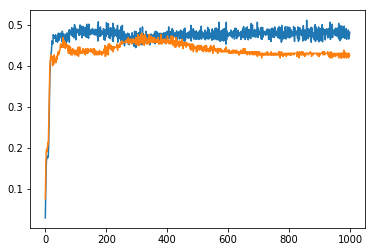

In [49]:
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000,)

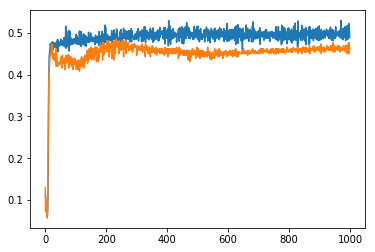

In [53]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

## (1000, 500)

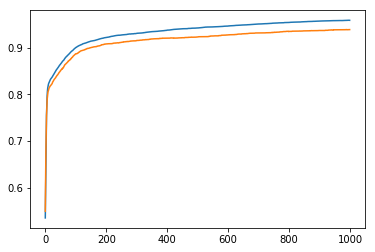

In [79]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])